In [96]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

## Reading

In [97]:
df = pd.read_csv("oasis_longitudinal.csv")

### Set random state

In [98]:
RANDOM_STATE = 13

## EDA

In [99]:
# MR Delay
# after how many days visit based on first visit

# EDUC
# How many years educate

# SES
# Socioeconomic Status
# 5 means LOW and 1 means HIGH?

# MMSE
# Mini‐Mental State Examination

# CDR
# Clinical Dementia Rating

# eTIV
# Estimated total intracranial volume

# nWBV
# Normalize Whole Brain Volume

# ASF
# Atlas Scaling Factor

In [100]:
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [101]:
df.tail()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
368,OAS2_0185,OAS2_0185_MR2,Demented,2,842,M,R,82,16,1.0,28.0,0.5,1693,0.694,1.037
369,OAS2_0185,OAS2_0185_MR3,Demented,3,2297,M,R,86,16,1.0,26.0,0.5,1688,0.675,1.040
370,OAS2_0186,OAS2_0186_MR1,Nondemented,1,0,F,R,61,13,2.0,30.0,0.0,1319,0.801,1.331
371,OAS2_0186,OAS2_0186_MR2,Nondemented,2,763,F,R,63,13,2.0,30.0,0.0,1327,0.796,1.323
372,OAS2_0186,OAS2_0186_MR3,Nondemented,3,1608,F,R,65,13,2.0,30.0,0.0,1333,0.801,1.317


In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    int64  
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(5), int64(5), object(5)
memory usage: 43.8+ KB


In [103]:
df.describe()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373.000000,373.000000,373.000000,373.000000,354.000000,371.000000,373.000000,373.000000,373.000000,373.000000
mean,1.882038,595.104558,77.013405,14.597855,2.460452,27.342318,0.290885,1488.128686,0.729568,1.195461
std,0.922843,635.485118,7.640957,2.876339,1.134005,3.683244,0.374557,176.139286,0.037135,0.138092
min,1.000000,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000
25%,1.000000,0.000000,71.000000,12.000000,2.000000,27.000000,0.000000,1357.000000,0.700000,1.099000
50%,2.000000,552.000000,77.000000,15.000000,2.000000,29.000000,0.000000,1470.000000,0.729000,1.194000
75%,2.000000,873.000000,82.000000,16.000000,3.000000,30.000000,0.500000,1597.000000,0.756000,1.293000
max,5.000000,2639.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.587000


## Preprocessing

### Handeling SES nan values 

<AxesSubplot: >

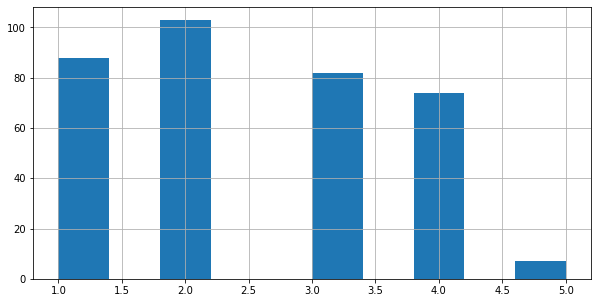

In [104]:
df.SES.hist(figsize = (10,5))

In [105]:
df.SES.mean()

2.4604519774011298

In [106]:
df.SES.unique()

array([ 2., nan,  3.,  4.,  1.,  5.])

In [107]:
df.groupby(["SES"]).mean()

/tmp/ipykernel_5093/2585948393.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(["SES"]).mean()


,Visit,MR Delay,Age,EDUC,MMSE,CDR,eTIV,nWBV,ASF
SES,,,,,,,,,
1.0,2.011364,672.181818,77.829545,17.340909,27.602273,0.301136,1571.204545,0.716614,1.131739
2.0,1.815534,562.961165,76.679612,15.446602,28.067961,0.179612,1489.339806,0.735223,1.195087
3.0,1.865854,555.634146,77.243902,13.987805,27.573171,0.280488,1442.573171,0.741890,1.229829
4.0,1.864865,632.851351,76.243243,11.959459,26.378378,0.337838,1460.202703,0.725595,1.214378
5.0,1.714286,478.428571,78.142857,8.000000,24.285714,0.428571,1349.000000,0.722571,1.314429


In [108]:
# fill nan values function for SES
def fill_ses(x):
    ses = 0
    if x > 17:
        ses = 1.0
    elif (x < 17) and (x > 15):
        ses = 2.0
    elif (x < 15) and (x > 13):
        ses = 3.0
    elif (x < 13) and (x > 11):
        ses = 4.0
    else:
        ses = 5.0
    return ses

In [109]:
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [110]:
df["SES"] = df.apply(lambda x : fill_ses(x.EDUC) if pd.isna(x.SES)   else x.SES, axis = 1)

In [111]:
# convert float to int to use less memory
df["SES"] = df.SES.astype(int)

In [112]:
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,4,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,4,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,4,22.0,0.5,1698,0.701,1.034


### Handeling MMSE nan values 

<AxesSubplot: >

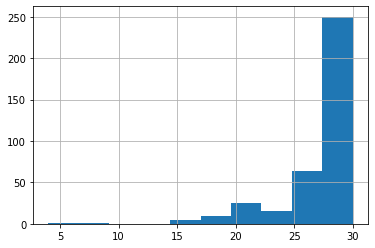

In [113]:
df.MMSE.hist()

In [114]:
df.groupby(["MMSE"]).mean()

/tmp/ipykernel_5093/685721936.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(["MMSE"]).mean()


,Visit,MR Delay,Age,EDUC,SES,CDR,eTIV,nWBV,ASF
MMSE,,,,,,,,,
4.0,5.000000,1233.000000,69.000000,16.000000,1.000000,1.000000,1701.000000,0.676000,1.032000
7.0,4.000000,970.000000,68.000000,16.000000,1.000000,1.000000,1714.000000,0.682000,1.024000
15.0,2.000000,473.500000,73.500000,14.000000,3.500000,1.500000,1366.000000,0.689000,1.285500
16.0,2.333333,841.000000,73.666667,13.333333,3.666667,1.000000,1520.000000,0.705667,1.156000
17.0,1.800000,524.000000,70.000000,12.800000,3.200000,0.800000,1569.000000,0.701400,1.122600
18.0,2.500000,1023.000000,78.500000,10.000000,3.500000,0.750000,1471.500000,0.669500,1.193000
19.0,1.666667,215.666667,69.000000,14.666667,1.333333,1.000000,1560.333333,0.710000,1.146000
20.0,1.571429,372.857143,78.428571,13.285714,3.000000,0.714286,1555.000000,0.700429,1.138000
21.0,1.545455,315.636364,78.181818,14.181818,3.000000,0.909091,1439.000000,0.683727,1.232091


In [115]:
df["MMSE"].mean()

27.342318059299192

In [116]:
df["MMSE"].median()

29.0

In [117]:
df[df["MMSE"].isna()]

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
357,OAS2_0181,OAS2_0181_MR2,Demented,2,539,F,R,75,12,4,NaN,1.0,1169,0.742,1.501
358,OAS2_0181,OAS2_0181_MR3,Demented,3,1107,F,R,77,12,4,NaN,1.0,1159,0.733,1.515


In [118]:
df[df["Group"] == "Demented"]["MMSE"].median()

26.0

In [119]:
df[df["MMSE"] < 26]["Group"].unique()

array(['Demented', 'Converted'], dtype=object)

In [120]:
df["MMSE"] = df.MMSE.fillna(df[df["Group"] == "Demented"]["MMSE"].median())

### Replace M/F values

In [121]:
df["M/F"] = np.where(df["M/F"] == "M", 1, 0)

### Drop Hand & MRI ID

In [122]:
df.drop(["Hand", "MRI ID"], axis = 1, inplace = True)

### Handeling Visits

In [123]:
# 11
df.iloc[10:13,:]

,Subject ID,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
10,OAS2_0007,Demented,1,0,1,71,16,2,28.0,0.5,1357,0.748,1.293
11,OAS2_0007,Demented,3,518,1,73,16,2,27.0,1.0,1365,0.727,1.286
12,OAS2_0007,Demented,4,1281,1,75,16,2,27.0,1.0,1372,0.710,1.279


In [124]:
# 11
df.loc[11,'Visit'] = 2
df.loc[12,'Visit'] = 3
df.iloc[10:13,:]

,Subject ID,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
10,OAS2_0007,Demented,1,0,1,71,16,2,28.0,0.5,1357,0.748,1.293
11,OAS2_0007,Demented,2,518,1,73,16,2,27.0,1.0,1365,0.727,1.286
12,OAS2_0007,Demented,3,1281,1,75,16,2,27.0,1.0,1372,0.710,1.279


In [125]:
# 30
df.iloc[29:33,:]

,Subject ID,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
29,OAS2_0017,Nondemented,1,0,1,80,12,3,29.0,0.0,1783,0.752,0.985
30,OAS2_0017,Nondemented,3,617,1,81,12,3,27.0,0.5,1814,0.759,0.968
31,OAS2_0017,Nondemented,4,1861,1,85,12,3,30.0,0.0,1820,0.755,0.964
32,OAS2_0017,Nondemented,5,2400,1,86,12,3,27.0,0.0,1813,0.761,0.968


In [126]:
# 30
df.loc[30,'Visit'] = 2
df.loc[31,'Visit'] = 3
df.loc[32,'Visit'] = 4
df.iloc[29:33,:]

,Subject ID,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
29,OAS2_0017,Nondemented,1,0,1,80,12,3,29.0,0.0,1783,0.752,0.985
30,OAS2_0017,Nondemented,2,617,1,81,12,3,27.0,0.5,1814,0.759,0.968
31,OAS2_0017,Nondemented,3,1861,1,85,12,3,30.0,0.0,1820,0.755,0.964
32,OAS2_0017,Nondemented,4,2400,1,86,12,3,27.0,0.0,1813,0.761,0.968


In [127]:
# 34
df.iloc[33:36,:]

,Subject ID,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
33,OAS2_0018,Converted,1,0,0,87,14,1,30.0,0.0,1406,0.715,1.248
34,OAS2_0018,Converted,3,489,0,88,14,1,29.0,0.0,1398,0.713,1.255
35,OAS2_0018,Converted,4,1933,0,92,14,1,27.0,0.5,1423,0.696,1.234


In [128]:
# 34
df.loc[34,'Visit'] = 2
df.loc[35,'Visit'] = 3
df.iloc[33:36,:]

,Subject ID,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
33,OAS2_0018,Converted,1,0,0,87,14,1,30.0,0.0,1406,0.715,1.248
34,OAS2_0018,Converted,2,489,0,88,14,1,29.0,0.0,1398,0.713,1.255
35,OAS2_0018,Converted,3,1933,0,92,14,1,27.0,0.5,1423,0.696,1.234


In [129]:
# 69
df.iloc[68:71]

,Subject ID,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
68,OAS2_0036,Nondemented,1,0,0,69,13,4,30.0,0.0,1359,0.789,1.291
69,OAS2_0036,Nondemented,3,713,0,70,13,4,30.0,0.0,1361,0.783,1.290
70,OAS2_0036,Nondemented,4,1770,0,73,13,4,30.0,0.0,1360,0.773,1.291


In [130]:
# 69
df.loc[69,'Visit'] = 2
df.loc[70,'Visit'] = 3
df.iloc[68:71]

,Subject ID,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
68,OAS2_0036,Nondemented,1,0,0,69,13,4,30.0,0.0,1359,0.789,1.291
69,OAS2_0036,Nondemented,2,713,0,70,13,4,30.0,0.0,1361,0.783,1.290
70,OAS2_0036,Nondemented,3,1770,0,73,13,4,30.0,0.0,1360,0.773,1.291


In [131]:
# 188
df.iloc[187:189]

,Subject ID,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
187,OAS2_0089,Demented,1,0,1,70,12,2,29.0,0.5,1432,0.692,1.225
188,OAS2_0089,Demented,3,563,1,72,12,2,27.0,1.0,1432,0.684,1.226


In [132]:
# 188
df.loc[188,'Visit'] = 2
df.iloc[187:189]

,Subject ID,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
187,OAS2_0089,Demented,1,0,1,70,12,2,29.0,0.5,1432,0.692,1.225
188,OAS2_0089,Demented,2,563,1,72,12,2,27.0,1.0,1432,0.684,1.226


In [133]:
# 274
df.iloc[273:275]

,Subject ID,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
273,OAS2_0133,Converted,1,0,0,78,12,3,29.0,0.0,1475,0.731,1.190
274,OAS2_0133,Converted,3,1006,0,81,12,3,28.0,0.5,1495,0.687,1.174


In [134]:
# 274
df.loc[274,'Visit'] = 2
df.iloc[273:275]

,Subject ID,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
273,OAS2_0133,Converted,1,0,0,78,12,3,29.0,0.0,1475,0.731,1.190
274,OAS2_0133,Converted,2,1006,0,81,12,3,28.0,0.5,1495,0.687,1.174


### Cut only firsts and seconds visits

In [135]:
df_copy = df.copy()
df = df[df["Visit"] < 3]

In [136]:
df

,Subject ID,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,Nondemented,1,0,1,87,14,2,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,Nondemented,2,457,1,88,14,2,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,Demented,1,0,1,75,12,4,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,Demented,2,560,1,76,12,4,28.0,0.5,1738,0.713,1.010
5,OAS2_0004,Nondemented,1,0,0,88,18,3,28.0,0.0,1215,0.710,1.444
...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,OAS2_0184,Demented,2,553,0,73,16,3,21.0,1.0,1351,0.708,1.299
367,OAS2_0185,Demented,1,0,1,80,16,1,28.0,0.5,1704,0.711,1.030
368,OAS2_0185,Demented,2,842,1,82,16,1,28.0,0.5,1693,0.694,1.037
370,OAS2_0186,Nondemented,1,0,0,61,13,2,30.0,0.0,1319,0.801,1.331


### Replace Group values

Example of how **Converted** Group should be handeled:

- before:

    - Subject ID = OAS2_0020,Group = Converted, Visit = 1

    - Subject ID = OAS2_0020,Group = Converted, Visit = 2
 
- after:

    - Subject ID = OAS2_0020,Group = Nondemented, Visit = 1

    - Subject ID = OAS2_0020,Group = Demented, Visit = 2
 

In [137]:
df.iloc[20:30]

,Subject ID,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
25,OAS2_0014,Demented,1,0,1,76,16,3,21.0,0.5,1602,0.697,1.096
26,OAS2_0014,Demented,2,504,1,77,16,3,16.0,1.0,1590,0.696,1.104
27,OAS2_0016,Demented,1,0,1,88,8,4,25.0,0.5,1651,0.660,1.063
28,OAS2_0016,Demented,2,707,1,90,8,4,23.0,0.5,1668,0.646,1.052
29,OAS2_0017,Nondemented,1,0,1,80,12,3,29.0,0.0,1783,0.752,0.985
30,OAS2_0017,Nondemented,2,617,1,81,12,3,27.0,0.5,1814,0.759,0.968
33,OAS2_0018,Converted,1,0,0,87,14,1,30.0,0.0,1406,0.715,1.248
34,OAS2_0018,Converted,2,489,0,88,14,1,29.0,0.0,1398,0.713,1.255
36,OAS2_0020,Converted,1,0,1,80,20,1,29.0,0.0,1587,0.693,1.106
37,OAS2_0020,Converted,2,756,1,82,20,1,28.0,0.5,1606,0.677,1.093


In [138]:
max_visit = df[df["Group"] == "Converted"].groupby(["Subject ID"]).max().reset_index()[["Subject ID","Visit"]]
for i in range(max_visit.shape[0]):
    target_index =  df[(df["Subject ID"] == max_visit.loc[i,"Subject ID"]) & (df["Visit"] != max_visit.loc[i,"Visit"]) ].index
    df.loc[target_index,"Group"] = "Nondemented"

In [139]:
df.iloc[20:30]

,Subject ID,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
25,OAS2_0014,Demented,1,0,1,76,16,3,21.0,0.5,1602,0.697,1.096
26,OAS2_0014,Demented,2,504,1,77,16,3,16.0,1.0,1590,0.696,1.104
27,OAS2_0016,Demented,1,0,1,88,8,4,25.0,0.5,1651,0.660,1.063
28,OAS2_0016,Demented,2,707,1,90,8,4,23.0,0.5,1668,0.646,1.052
29,OAS2_0017,Nondemented,1,0,1,80,12,3,29.0,0.0,1783,0.752,0.985
30,OAS2_0017,Nondemented,2,617,1,81,12,3,27.0,0.5,1814,0.759,0.968
33,OAS2_0018,Nondemented,1,0,0,87,14,1,30.0,0.0,1406,0.715,1.248
34,OAS2_0018,Converted,2,489,0,88,14,1,29.0,0.0,1398,0.713,1.255
36,OAS2_0020,Nondemented,1,0,1,80,20,1,29.0,0.0,1587,0.693,1.106
37,OAS2_0020,Converted,2,756,1,82,20,1,28.0,0.5,1606,0.677,1.093


In [140]:
df["Group"] = np.where(df["Group"] == "Nondemented", 0, 1)

In [141]:
df.iloc[20:30]

,Subject ID,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
25,OAS2_0014,1,1,0,1,76,16,3,21.0,0.5,1602,0.697,1.096
26,OAS2_0014,1,2,504,1,77,16,3,16.0,1.0,1590,0.696,1.104
27,OAS2_0016,1,1,0,1,88,8,4,25.0,0.5,1651,0.660,1.063
28,OAS2_0016,1,2,707,1,90,8,4,23.0,0.5,1668,0.646,1.052
29,OAS2_0017,0,1,0,1,80,12,3,29.0,0.0,1783,0.752,0.985
30,OAS2_0017,0,2,617,1,81,12,3,27.0,0.5,1814,0.759,0.968
33,OAS2_0018,0,1,0,0,87,14,1,30.0,0.0,1406,0.715,1.248
34,OAS2_0018,1,2,489,0,88,14,1,29.0,0.0,1398,0.713,1.255
36,OAS2_0020,0,1,0,1,80,20,1,29.0,0.0,1587,0.693,1.106
37,OAS2_0020,1,2,756,1,82,20,1,28.0,0.5,1606,0.677,1.093


## Processing

### A list to remember and compare details

In [142]:
model_details = []

### Split Data

In [143]:
# GroupShuffleSplit should be used because it is important to model to learn each patient fully (all visit for each patient).
splitter = GroupShuffleSplit(test_size=.20, n_splits=1, random_state = RANDOM_STATE)

In [144]:
split = splitter.split(df, groups=df['Subject ID'])
train_indexes, test_indexes = next(split)

train = df.iloc[train_indexes]
test = df.iloc[test_indexes]

In [145]:
X_train = train.drop(["Subject ID", "Group"], axis = 1)
y_train = train[["Group"]]

In [146]:
X_test = test.drop(["Subject ID", "Group"], axis = 1)
y_test = test[["Group"]]

### Normalization

In [147]:
delay_scaler = MinMaxScaler()
age_scaler = MinMaxScaler()
educ_scaler = MinMaxScaler()
mmse_scaler = MinMaxScaler()
etiv_scaler = MinMaxScaler()

delay_scaler.fit(X_train["MR Delay"].to_numpy().reshape(-1,1))
age_scaler.fit(X_train["Age"].to_numpy().reshape(-1,1))
educ_scaler.fit(X_train["EDUC"].to_numpy().reshape(-1,1))
mmse_scaler.fit(X_train["MMSE"].to_numpy().reshape(-1,1))
etiv_scaler.fit(X_train["eTIV"].to_numpy().reshape(-1,1))

X_train["MR Delay"] = delay_scaler.transform(X_train["MR Delay"].to_numpy().reshape(-1,1))
X_train["Age"] = age_scaler.transform(X_train["Age"].to_numpy().reshape(-1,1))
X_train["EDUC"] = educ_scaler.transform(X_train["EDUC"].to_numpy().reshape(-1,1))
X_train["MMSE"] = mmse_scaler.transform(X_train["MMSE"].to_numpy().reshape(-1,1))
X_train["eTIV"] = etiv_scaler.transform(X_train["eTIV"].to_numpy().reshape(-1,1))

X_test["MR Delay"] = delay_scaler.transform(X_test["MR Delay"].to_numpy().reshape(-1,1))
X_test["Age"] = age_scaler.transform(X_test["Age"].to_numpy().reshape(-1,1))
X_test["EDUC"] = educ_scaler.transform(X_test["EDUC"].to_numpy().reshape(-1,1))
X_test["MMSE"] = mmse_scaler.transform(X_test["MMSE"].to_numpy().reshape(-1,1))
X_test["eTIV"] = etiv_scaler.transform(X_test["eTIV"].to_numpy().reshape(-1,1))

### Logestic Regression

              precision    recall  f1-score   support

Non-Demanted       1.00      1.00      1.00        30
    Demanted       1.00      1.00      1.00        30

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



/home/amyrmahdy/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


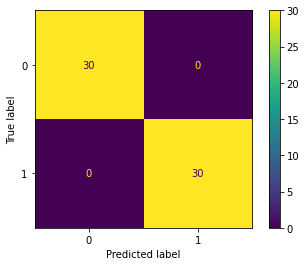

In [148]:
lr = LogisticRegression( max_iter = 1000)
lr.fit(X_train, y_train)
lr_prediction = lr.predict(X_test)
print(classification_report(y_test,lr_prediction, target_names= ["Non-Demanted", "Demanted"]))
lr_conf = confusion_matrix(y_test,lr_prediction)
model_details.append(["LogisticRegression", round(f1_score(y_test,lr_prediction, average = "weighted") * 100,4),lr_conf[1,0]])
lr_plot_conf = ConfusionMatrixDisplay(lr_conf)
lr_plot_conf.plot()

### RandomForest Classification

/tmp/ipykernel_5093/450862791.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


              precision    recall  f1-score   support

Non-Demanted       1.00      1.00      1.00        30
    Demanted       1.00      1.00      1.00        30

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



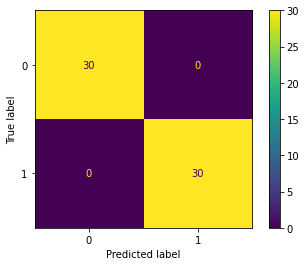

In [149]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_prediction = rfc.predict(X_test)
print(classification_report(y_test,rfc_prediction, target_names= ["Non-Demanted", "Demanted"]))
rfc_conf = confusion_matrix(y_test,rfc_prediction)
model_details.append(["RandomForestClassifier", round(f1_score(y_test,rfc_prediction, average = "weighted") * 100,4),rfc_conf[1,0]])
rfc_plot_conf = ConfusionMatrixDisplay(rfc_conf)
rfc_plot_conf.plot()

### LinearSVC

              precision    recall  f1-score   support

Non-Demanted       1.00      1.00      1.00        30
    Demanted       1.00      1.00      1.00        30

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



/home/amyrmahdy/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


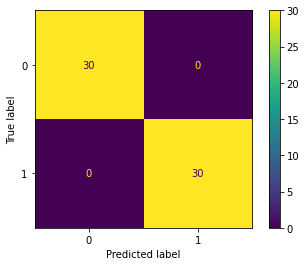

In [150]:
lsvc = LinearSVC(max_iter = 100000)
lsvc.fit(X_train, y_train)
lsvc_prediction = lsvc.predict(X_test)
print(classification_report(y_test,lsvc_prediction, target_names= ["Non-Demanted", "Demanted"]))
lsvc_conf = confusion_matrix(y_test,lsvc_prediction)
model_details.append(["LinearSVC", round(f1_score(y_test,lsvc_prediction, average = "weighted") * 100,4),lsvc_conf[1,0]])
lsvc_plot_conf = ConfusionMatrixDisplay(lsvc_conf)
lsvc_plot_conf.plot()

### Simple Neural Network

In [151]:
def build_snn():
    snn = tf.keras.Sequential()
    snn.add(tf.keras.layers.InputLayer(X_train.shape[1],))
    snn.add(tf.keras.layers.Dense(100,activation = "relu"))
    snn.add(tf.keras.layers.Dense(50,activation = "relu"))
    snn.add(tf.keras.layers.Dense(1,activation = "sigmoid"))
    snn.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
    return snn

2023-01-01 07:12:14.215748: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-01 07:12:14.269128: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-01 07:12:14.269178: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cando): /proc/driver/nvidia/version does not exist
2023-01-01 07:12:14.313800: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
8/8 [==============================] - 2s 3ms/step - loss: 0.6882 - accuracy: 0.5375
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 0.6523 - accuracy: 0.8083
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6245 - accuracy: 0.8542
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 0.5934 - accuracy: 0.8333
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 0.5562 - accuracy: 0.8708
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 0.5124 - accuracy: 0.9208
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 0.4662 - accuracy: 0.9125
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 0.4204 - accuracy: 0.9167
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 0.3778 - accuracy: 0.9458
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 0.3283 - accuracy: 0.9542
Epoch 11/100
8/8 [===========

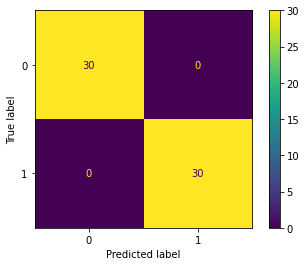

In [152]:
snn = build_snn()
snn.fit(X_train, y_train, epochs = 100)
not_final_snn_prediction = snn.predict(X_test)
snn_prediction = np.where(not_final_snn_prediction > 0.5, 1, 0)
print(classification_report(y_test,snn_prediction, target_names= ["Non-Demanted", "Demanted"]))
snn_conf = confusion_matrix(y_test,snn_prediction)
model_details.append(["SNN", round(f1_score(y_test,snn_prediction, average = "weighted") * 100,4),snn_conf[1,0]])
snn_plot_conf = ConfusionMatrixDisplay(snn_conf)
snn_plot_conf.plot()

### RNN LSTM

In [153]:
def build_lstm_rnn():
    lstm_rnn = tf.keras.Sequential()
    lstm_rnn.add(tf.keras.layers.LSTM(100, return_sequences = True,input_shape = (X_train.shape[1],1) ) )
    lstm_rnn.add(tf.keras.layers.LSTM(50,return_sequences = False))
    lstm_rnn.add(tf.keras.layers.Dense(1,activation = "sigmoid"))
    lstm_rnn.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
    return lstm_rnn

Epoch 1/100
8/8 [==============================] - 5s 14ms/step - loss: 0.6948 - accuracy: 0.5083
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.6916 - accuracy: 0.5542
Epoch 3/100
8/8 [==============================] - 0s 14ms/step - loss: 0.6887 - accuracy: 0.6417
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 0.6863 - accuracy: 0.6417
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.6827 - accuracy: 0.5750
Epoch 6/100
8/8 [==============================] - 0s 14ms/step - loss: 0.6767 - accuracy: 0.6208
Epoch 7/100
8/8 [==============================] - 0s 14ms/step - loss: 0.6660 - accuracy: 0.6292
Epoch 8/100
8/8 [==============================] - 0s 14ms/step - loss: 0.6701 - accuracy: 0.5708
Epoch 9/100
8/8 [==============================] - 0s 15ms/step - loss: 0.6499 - accuracy: 0.5958
Epoch 10/100
8/8 [==============================] - 0s 14ms/step - loss: 0.6421 - accuracy: 0.6583
Epoch 11/100
8/8 [=

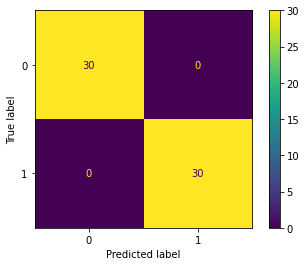

In [154]:
lstm_rnn = build_lstm_rnn()
lstm_rnn.fit(X_train, y_train, epochs = 100)
not_final_lstm_rnn_prediction = lstm_rnn.predict(X_test)
lstm_rnn_prediction = np.where(not_final_lstm_rnn_prediction > 0.5, 1, 0)
print(classification_report(y_test,lstm_rnn_prediction, target_names= ["Non-Demanted", "Demanted"]))
lstm_rnn_conf = confusion_matrix(y_test,lstm_rnn_prediction)
model_details.append(["LSTM RNN", round(f1_score(y_test,lstm_rnn_prediction, average = "weighted") * 100,4),lstm_rnn_conf[1,0]])
lstm_rnn_plot_conf = ConfusionMatrixDisplay(lstm_rnn_conf)
lstm_rnn_plot_conf.plot()

### RNN GRU

In [155]:
def build_gru_rnn():
    gru_rnn = tf.keras.Sequential()
    gru_rnn.add(tf.keras.layers.GRU(100, return_sequences = True,input_shape = (X_train.shape[1],1) ) )
    gru_rnn.add(tf.keras.layers.GRU(50,return_sequences = False))
    gru_rnn.add(tf.keras.layers.Dense(1,activation = "sigmoid"))
    gru_rnn.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
    return gru_rnn

Epoch 1/100
8/8 [==============================] - 5s 18ms/step - loss: 0.6938 - accuracy: 0.5417
Epoch 2/100
8/8 [==============================] - 0s 19ms/step - loss: 0.6904 - accuracy: 0.5208
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 0.6872 - accuracy: 0.5833
Epoch 4/100
8/8 [==============================] - 0s 18ms/step - loss: 0.6851 - accuracy: 0.5708
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.6753 - accuracy: 0.6667
Epoch 6/100
8/8 [==============================] - 0s 16ms/step - loss: 0.6707 - accuracy: 0.6667
Epoch 7/100
8/8 [==============================] - 0s 13ms/step - loss: 0.6592 - accuracy: 0.6792
Epoch 8/100
8/8 [==============================] - 0s 17ms/step - loss: 0.6487 - accuracy: 0.6667
Epoch 9/100
8/8 [==============================] - 0s 18ms/step - loss: 0.6355 - accuracy: 0.6625
Epoch 10/100
8/8 [==============================] - 0s 12ms/step - loss: 0.6260 - accuracy: 0.6583
Epoch 11/100
8/8 [=

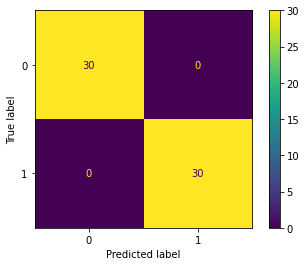

In [156]:
gru_rnn = build_gru_rnn()
gru_rnn.fit(X_train, y_train, epochs = 100)
not_final_gru_rnn_prediction = gru_rnn.predict(X_test)
gru_rnn_prediction = np.where(not_final_gru_rnn_prediction > 0.5, 1, 0)
print(classification_report(y_test,gru_rnn_prediction, target_names= ["Non-Demanted", "Demanted"]))
gru_rnn_conf = confusion_matrix(y_test,gru_rnn_prediction)
model_details.append(["GRU RNN", round(f1_score(y_test,gru_rnn_prediction, average = "weighted") * 100,4),gru_rnn_conf[1,0]])
gru_rnn_plot_conf = ConfusionMatrixDisplay(gru_rnn_conf)
gru_rnn_plot_conf.plot()

## Result

In [157]:
models = pd.DataFrame(model_details, columns = ["model","score","false_negatives"])
models = models.sort_values(["false_negatives"]).reset_index(drop = True)
models

,model,score,false_negatives
0,LogisticRegression,100.0,0
1,RandomForestClassifier,100.0,0
2,LinearSVC,100.0,0
3,SNN,100.0,0
4,LSTM RNN,100.0,0
5,GRU RNN,100.0,0


In [158]:
models.to_csv(f"v4_details_random_state_{RANDOM_STATE}.csv", index = False)

In [159]:
# Author: amyrmahdy
# Date: 1 Jan 2022